In [24]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import PIL
import os
from os import walk
import glob

In [38]:
tr = transforms.Compose([transforms.ToTensor(),transforms.Resize(64)])

In [39]:
print(os.listdir("../input"))

['cifar100-100x100-images-extension', 'asl-alphabet']


In [40]:
for (dirpath, dirnames, filenames) in walk("../input/"):
    print("Directory path: ", dirpath)
    print("Folder name: ", dirnames)
    break

Directory path:  ../input/
Folder name:  ['cifar100-100x100-images-extension', 'asl-alphabet']


In [62]:
test_datasets=torchvision.datasets.ImageFolder("../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train",transform=tr)

In [63]:
train_datasets=torchvision.datasets.ImageFolder("../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train",transform=tr)

In [64]:
batch_size=512
train_loader=torch.utils.data.DataLoader(dataset=train_datasets,
                                         batch_size=batch_size,
                                         shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_datasets,
                                         batch_size=batch_size,
                                         shuffle=True)

In [65]:
# number of classes
# K = len(set(train_dataset.targets.numpy()))
K = len(os.listdir("../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"))
print("number of classes:", K)

number of classes: 29


In [66]:
# Define the model
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__()
    self.model = nn.Sequential(
    nn.Conv2d(in_channels = 3, out_channels=32, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Dropout(0.2),
    nn.Linear(128 * 7 * 7, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, K)   
)
  
  def forward(self, X):
    out = self.model(X)
    return out




In [67]:
model=CNN(K)

In [68]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=6272, out_features=512, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.2, inplace=False)
    (11): Linear(in_features=512, out_features=29, bias=True)
  )
)

In [69]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [70]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading
    
    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [72]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, epochs=10)

Epoch 1/10, Train Loss: 0.2573,       Test Loss: 0.0964, Duration: 0:05:46.572931
Epoch 2/10, Train Loss: 0.2040,       Test Loss: 0.0802, Duration: 0:05:55.356545
Epoch 3/10, Train Loss: 0.1667,       Test Loss: 0.0590, Duration: 0:05:45.405763
Epoch 4/10, Train Loss: 0.1283,       Test Loss: 0.0439, Duration: 0:05:48.231267
Epoch 5/10, Train Loss: 0.1215,       Test Loss: 0.0390, Duration: 0:05:50.319826
Epoch 6/10, Train Loss: 0.1113,       Test Loss: 0.0245, Duration: 0:05:44.565919
Epoch 7/10, Train Loss: 0.0949,       Test Loss: 0.0256, Duration: 0:05:44.499804
Epoch 8/10, Train Loss: 0.0804,       Test Loss: 0.0184, Duration: 0:05:45.640559
Epoch 9/10, Train Loss: 0.0778,       Test Loss: 0.0188, Duration: 0:05:44.580974
Epoch 10/10, Train Loss: 0.0727,       Test Loss: 0.0144, Duration: 0:05:50.653121


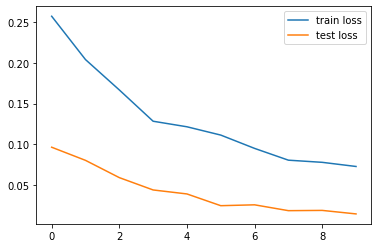

In [73]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [74]:
# Accuracy

model.eval()
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc*100:.4f}, Test acc: {test_acc*100:.4f}")

Train acc: 99.6644, Test acc: 99.6644


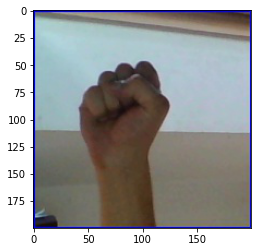

In [103]:
img = glob.glob("/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/S_test.jpg")
for image in img:
    images=PIL.Image.open(image)
    trans=transforms.ToPILImage()
    trans1=transforms.ToTensor()
    img_req = (trans1(images))
    plt.imshow(trans(trans1(images)))




In [104]:
type(img_req)

torch.Tensor

In [105]:
model.eval()

CNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=6272, out_features=512, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.2, inplace=False)
    (11): Linear(in_features=512, out_features=29, bias=True)
  )
)

In [106]:
img_req.shape

torch.Size([3, 200, 200])

In [107]:
tr

Compose(
    ToTensor()
    Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
)

In [108]:
# rgb_im = images.convert('RGB')

In [109]:
img = tr(images)

In [110]:
img = img.unsqueeze(dim=0)

In [111]:
img.shape

torch.Size([1, 3, 64, 64])

In [112]:
img = img.to(device)

In [113]:
item_labels = sorted(os.listdir("/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"))
item_labels

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

In [114]:
print(model(img))
max = torch.argmax(model(img))
print(f'Predicted image is {item_labels[max]}')

tensor([[ -5.0030, -40.1830, -41.2669, -40.9815,  -8.1461, -15.3363, -42.8126,
         -54.1315,   1.6624,  -3.3585, -35.9050, -12.2796,  10.4106,   6.8892,
           2.8672, -32.1042, -15.3460, -21.3437,  24.9368,  10.6603, -40.0406,
         -39.9477, -26.5158,   8.0635,  -1.8209,  -7.3025, -12.2900, -39.7287,
         -54.5996]], device='cuda:0', grad_fn=<AddmmBackward0>)
Predicted image is S
